# FastFashOff - Détection de logos de fast fashion

Application de recherche d'image par contenu pour détecter les logos de marques de fast fashion et sensibiliser aux impacts sociaux et environnementaux.

**Projet réalisé dans le cadre du cours d'Informatique graphique et vision**  

## 1. Imports et configuration

In [9]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
   
#imports des modules de l'application
from config import LOGOS, IMAGES, LOGO_DIR, IMAGE_DIR, MIN_MATCHES, SEUIL_DISTANCE
from data_marques import MARQUES_INFO, LOGO_TO_MARQUE
from image_processing import load_image, filter_image, resize_image
from logo_detection import (extraire_features_orb,matcher_logos,filtrer_bons_matches,
valider_detection,dessiner_matches,valider_avec_homographie)
from display import afficher_info_boycott, afficher_image_opencv, afficher_resume
from utils import (valider_structure_projet,afficher_statistiques_detection,)

print("Modules chargés")


Modules chargés


## 2. Validation de la structure du projet


In [10]:
valide, message = valider_structure_projet()
print(message)

if valide:
    print("\nLogos disponibles :", len(LOGOS))
    for logo in LOGOS:
        print("- " + logo)
    
    print("\nImages disponibles :", len(IMAGES))
    for img in IMAGES:
        print("- " + img)

Structure du projet valide

Logos disponibles : 7
- Bershka-logo.png
- primark-logo.png
- zara_logo.png
- hm-logo.png
- Shein-logo.png
- uniqlo-logo.png
- Pull_Bear-logo.png

Images disponibles : 5
- BERSHKA.jpg
- PRIMARK.jpg
- ZARA.jpeg
- H&M.jpg
- SHEIN.jpeg


## 3. Visualisation des données


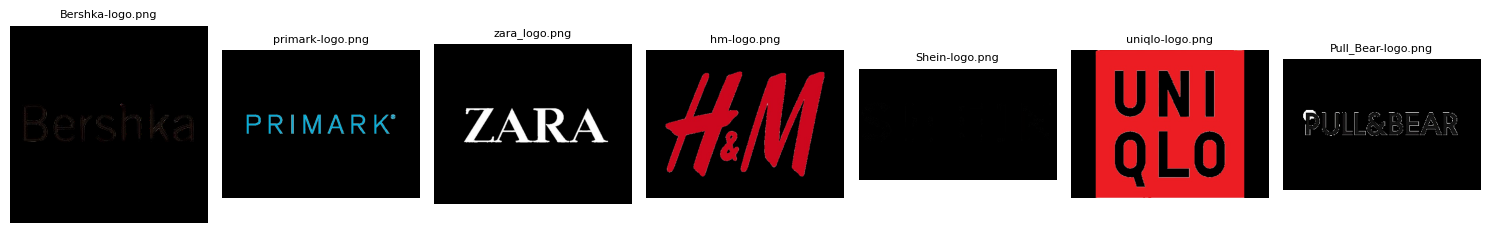

In [11]:
def afficher_logos_notebook():
    #on affiche tous les logos dans le notebook grace a matplotlib
    fig, axes = plt.subplots(1, len(LOGOS), figsize=(15, 3))
    
    for i, logo_name in enumerate(LOGOS):
        logo_path = LOGO_DIR / logo_name
        img = load_image(logo_path, grayscale=False)
        
        if img is not None:
            #on convertit l'image de BGR vers RGB pour l'affichage
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img_rgb)
            axes[i].set_title(logo_name, fontsize=8)
            axes[i].axis('off')
    
    #On ajuste automatiquement l'espacement
    plt.tight_layout()
    plt.show()

afficher_logos_notebook()


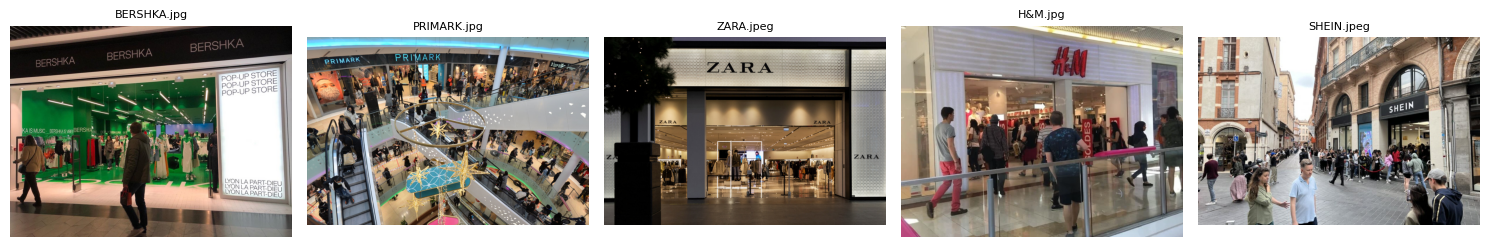

In [12]:
def afficher_images_notebook():
    #on affiche toutes les images du dataset dans le notebook
    fig, axes = plt.subplots(1, len(IMAGES), figsize=(15, 3))
    
    for i, img_name in enumerate(IMAGES):
        img_path = IMAGE_DIR / img_name
        img = load_image(img_path, grayscale=False)
        
        if img is not None:
            #on convertit l'image de BGR vers RGB pour matplotlib
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img_rgb)
            axes[i].set_title(img_name, fontsize=8)
            axes[i].axis('off')
    
    #On ajuste l'espacement pour que les images ne se chevauchent pas
    plt.tight_layout()
    plt.show()

afficher_images_notebook()


## 4. Test du filtre sur une image

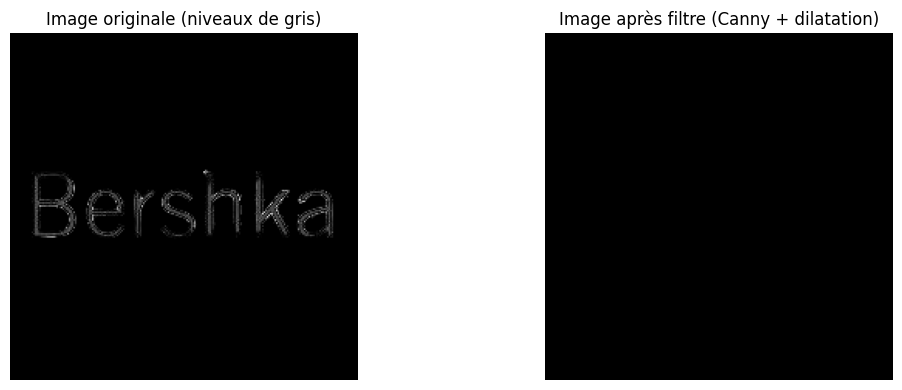

In [13]:
#on charge une image de test depuis les logos
test_img_path = LOGO_DIR / LOGOS[0]
img_original = load_image(test_img_path, grayscale=True)

#on applique le filtre à l'image
img_filtree = filter_image(img_original)

#On crée une figure pour afficher les images côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

#On affiche l'image originale en niveaux de gris
axes[0].imshow(img_original, cmap='gray')
axes[0].set_title('Image originale (niveaux de gris)')
axes[0].axis('off')

#On affiche l'image après application du filtre
axes[1].imshow(img_filtree, cmap='gray')
axes[1].set_title('Image après filtre (Canny + dilatation)')
axes[1].axis('off')

#on ajuste l'espacement pour que tout soit lisible
plt.tight_layout()
plt.show()


## 5. Test de détection ORB sur une paire logo/image

In [14]:
import os

def tester_detection_simple(index=0):
    if index >= len(LOGOS):
        print("Index", index, "hors limite, test ignoré")
        return

    logo_file = LOGOS[index]

    marque = LOGO_TO_MARQUE.get(logo_file)
    if marque == None:
        print("Aucune marque associée pour le logo", logo_file, "test ignoré")
        return
#on utilise le module os pour lister les fichiers du dossier image et extraire leur nom et extension
#cela permet de retrouver automatiquement l'image correspondant à une marque à partir du logo

    img_file = None
    for f in os.listdir(IMAGE_DIR):
        name, ext = os.path.splitext(f)
        if name.upper() == marque.upper():
            img_file = f
            break

    if img_file == None:
        print("Aucune image trouvée pour la marque", marque, "(", logo_file, "), test ignoré")
        return

    #on teste la détection sur une paire logo/image spécifique
    logo_path = LOGO_DIR / logo_file
    img_path = IMAGE_DIR / img_file
    
    print("Test :", logo_file, "vs", img_file, "\n")
    
    #on charge les images en niveaux de gris
    imgLogo = load_image(logo_path, grayscale=True)
    img = load_image(img_path, grayscale=True)

    if imgLogo is None or img is None:
        print("Erreur de chargement")
        return
    
    imgLogo_filtered = filter_image(imgLogo)
    img_filtered = filter_image(img)

    kp0, des0 = extraire_features_orb(imgLogo_filtered)
    kp1, des1 = extraire_features_orb(img_filtered)
    
    print("Keypoints logo :", len(kp0))
    print("Keypoints image :", len(kp1))
    
    if des0 is None or des1 is None:
        print("Pas de descripteurs")
        return
    
    matches = matcher_logos(des0, des1)
    good_matches = filtrer_bons_matches(matches, SEUIL_DISTANCE)
    
    print("\nMatches totaux :", len(matches))
    print("Bons matches (dist<", SEUIL_DISTANCE, ") :", len(good_matches))
    
    if matches:
        print("Distance min :", round(matches[0].distance, 1))
        print("Distance max :", round(matches[-1].distance, 1))
    
    #on vérifie si on valide la détection
    valide = valider_detection(matches, MIN_MATCHES, SEUIL_DISTANCE)
    if valide:
        print("Détection valide")
    else:
        print("Détection invalide")

    #on affiche ensuite le résultat
    img_matches = dessiner_matches(imgLogo_filtered, kp0, img_filtered, kp1, matches, 25)
    img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(15, 5))
    plt.imshow(img_matches_rgb)
    plt.title("Matching : " + logo_file + " vs " + img_file +" (" + str(len(good_matches)) + " bons matches)")
    plt.axis('off')
    plt.show()

tester_detection_simple(0)


Test : Bershka-logo.png vs BERSHKA.jpg 

Keypoints logo : 0
Keypoints image : 1000
Pas de descripteurs


Test : primark-logo.png vs PRIMARK.jpg 

Keypoints logo : 885
Keypoints image : 1000

Matches totaux : 16
Bons matches (dist< 50 ) : 15
Distance min : 21.0
Distance max : 65.0
Détection valide


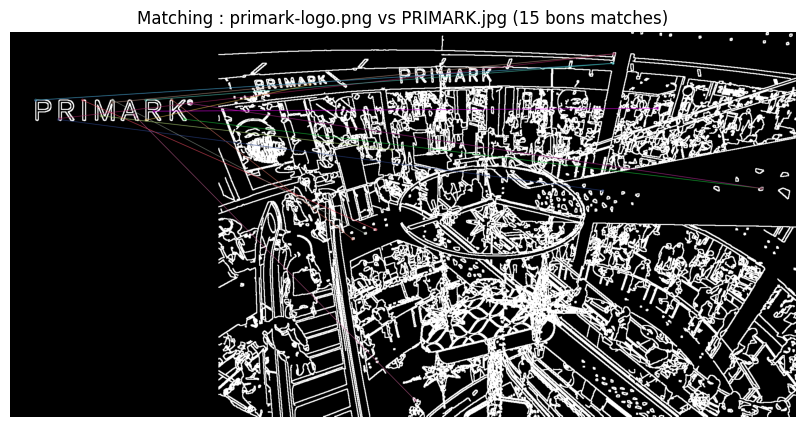

Test : zara_logo.png vs ZARA.jpeg 

Keypoints logo : 839
Keypoints image : 1000

Matches totaux : 30
Bons matches (dist< 50 ) : 27
Distance min : 9.0
Distance max : 58.0
Détection valide


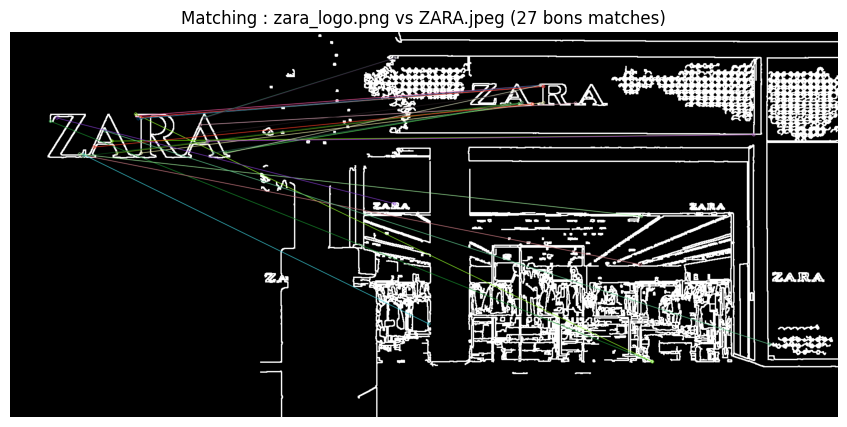

Test : hm-logo.png vs H&M.jpg 

Keypoints logo : 1018
Keypoints image : 1000

Matches totaux : 90
Bons matches (dist< 50 ) : 85
Distance min : 15.0
Distance max : 53.0
Détection valide


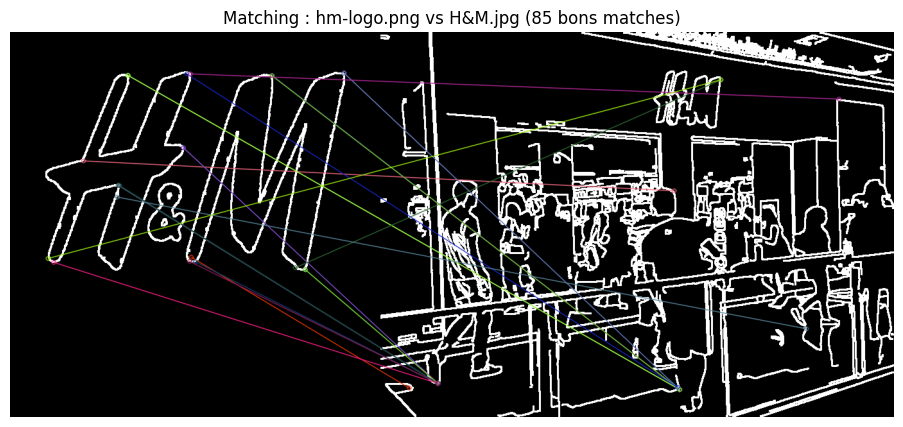

Test : Shein-logo.png vs SHEIN.jpeg 

Keypoints logo : 0
Keypoints image : 1000
Pas de descripteurs
Aucune image trouvée pour la marque Uniqlo ( uniqlo-logo.png ), test ignoré
Aucune image trouvée pour la marque Pull&Bear ( Pull_Bear-logo.png ), test ignoré


In [15]:
#on teste toutes les paires
for i in range(1, len(LOGOS)):
    tester_detection_simple(i)

## 6. Analyse complète du dataset


FASTFASHOFF - Analyse en cours...
Pas de descripteurs pour : Bershka-logo.png ou BERSHKA.jpg
Logo détecté : primark-logo.png
- Nombre de bons matches : 15
- Distance minimale : 21.0


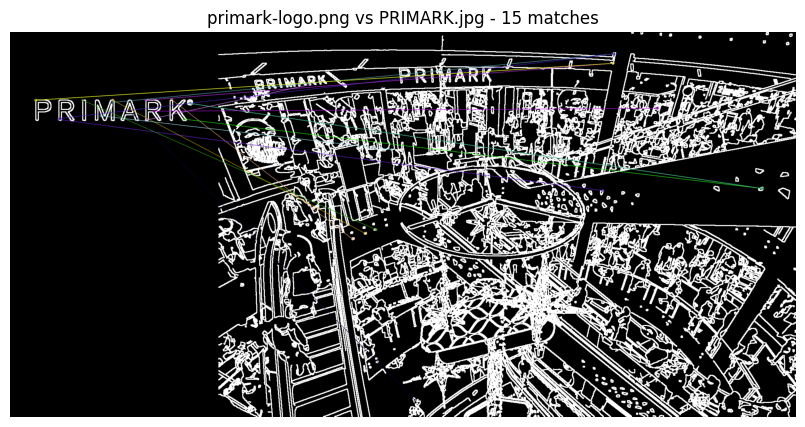


MARQUE DÉTECTÉE: Primark

Contexte:
   Impliqué dans l'effondrement du Rana Plaza (Bangladesh, 2013) qui a tué plus de 1100 personnes.

Raisons de boycotter:
   1. Salaires très bas et horaires excessifs pour les ouvriers
   2. Absence de transparence sur la chaîne d'approvisionnement
   3. Modèle économique basé sur l'ultra fast-fashion
   4. Utilisation massive de matières polluantes (polyester)

Alternatives recommandées:
   Friperies, location de vêtements, marques responsables
Logo détecté : zara_logo.png
- Nombre de bons matches : 27
- Distance minimale : 9.0


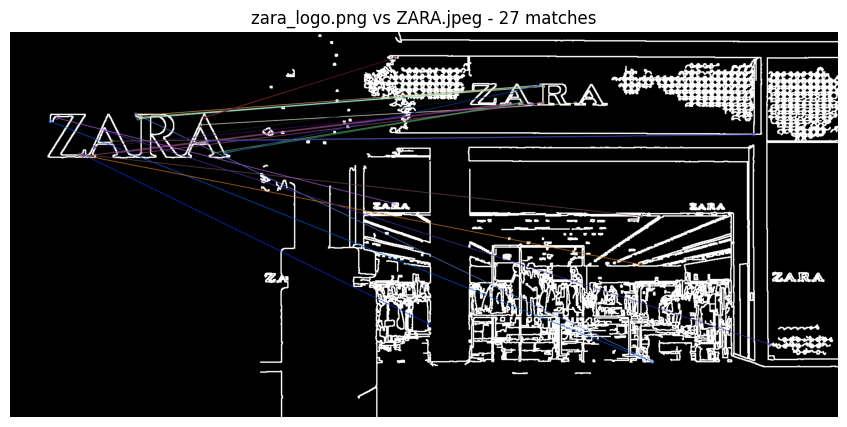


MARQUE DÉTECTÉE: Zara (groupe Inditex)

Contexte:
   Leader mondial de la fast fashion. Inditex est régulièrement pointé du doigt pour ses pratiques sociales et environnementales.

Raisons de boycotter:
   1. Rythme de production effréné (nouvelles collections toutes les 2 semaines)
   2. Exploitation des travailleurs dans les pays en développement
   3. Gaspillage textile massif (invendus détruits)
   4. Empreinte carbone élevée due à la logistique mondiale

Alternatives recommandées:
   Mode durable, upcycling, marques locales et transparentes
Logo détecté : hm-logo.png
- Nombre de bons matches : 85
- Distance minimale : 15.0


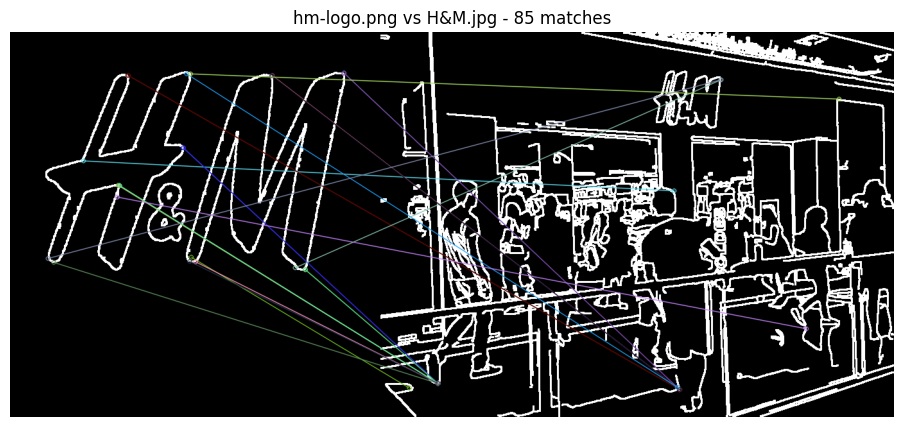


MARQUE DÉTECTÉE: H&M (Hennes & Mauritz)

Contexte:
   Malgré ses initiatives 'Conscious', H&M reste un acteur majeur de la fast fashion avec un impact environnemental considérable.

Raisons de boycotter:
   1. Pratiques de greenwashing (communication trompeuse sur l'écologie)
   2. Salaires insuffisants pour les ouvriers du textile
   3. Tonnes de vêtements invendus brûlés chaque année
   4. Conditions de travail dangereuses dans les usines partenaires

Alternatives recommandées:
   Achats responsables, réparation de vêtements, marques éthiques
Pas de descripteurs pour : Shein-logo.png ou SHEIN.jpeg

RÉSUMÉ DE L'ANALYSE
3 marque de fast fashion détectée:
   - Primark (15 correspondances)
   - Zara (27 correspondances)
   - H&M (85 correspondances)

Ces marques sont associées à:
   - Exploitation des travailleurs
   - Impact environnemental élevé
   - Modèle de surconsommation

Privilégiez les alternatives durables et éthiques!
Statistiques de détection:
  Nombre de détections : 3
  Ma

In [16]:
def analyser_dataset_notebook():
    #On lance l'analyse complète du dataset avec affichage dans le notebook
    print("\n"+"FASTFASHOFF - Analyse en cours...")

    #On enregistre le temps de départ pour mesurer la durée de l'analyse
    debut = time.time()     
    marques_detectees = []
    
    for i in range(len(IMAGES)):
        logo_path = LOGO_DIR / LOGOS[i]
        img_path = IMAGE_DIR / IMAGES[i]

        #On charge les images en niveaux de gris
        imgLogo=load_image(logo_path, grayscale=True)
        img=load_image(img_path, grayscale=True)

        if imgLogo is None or img is None:
            print("Impossible de lire :", LOGOS[i], "ou", IMAGES[i])
            continue

        #On applique le filtre sur les images
        imgLogo_filtered=filter_image(imgLogo)
        img_filtered=filter_image(img)

        #On extrait les keypoints et descripteurs ORB
        kp0,des0=extraire_features_orb(imgLogo_filtered)
        kp1,des1=extraire_features_orb(img_filtered)

        if des0 is None or des1 is None:
            print("Pas de descripteurs pour :", LOGOS[i], "ou", IMAGES[i])
            continue

        #On fait le matching entre les descripteurs
        matches=matcher_logos(des0, des1)
        good_matches=filtrer_bons_matches(matches, SEUIL_DISTANCE)
        
        #On vérifie si la détection est valide
        if valider_detection(matches, MIN_MATCHES, SEUIL_DISTANCE):
            #On prépare les infos de la détection
            detection = {
                "logo": LOGOS[i],
                "image": IMAGES[i],
                "matches": len(good_matches),
                "distance_min": matches[0].distance if matches else 0
            }
            marques_detectees.append(detection)
        
            print("Logo détecté :", LOGOS[i])
            print("- Nombre de bons matches :", len(good_matches))
            print("- Distance minimale :", round(matches[0].distance, 1))
            
            #On affiche le matching entre le logo et l'image
            img_matches=dessiner_matches(imgLogo_filtered, kp0, img_filtered, kp1, matches, 25)
            img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
            
            plt.figure(figsize=(15, 5))
            plt.imshow(img_matches_rgb)
            plt.title(LOGOS[i] + " vs " + IMAGES[i] + " - " + str(len(good_matches)) + " matches")
            plt.axis('off')
            plt.show()
            
            #On affiche les informations de boycott pour la marque détectée
            afficher_info_boycott(LOGOS[i])
        else:
            print("Pas de détection :", LOGOS[i], "vs", IMAGES[i])
            print("-Nombre de matches :", len(good_matches), "(minimum requis :", MIN_MATCHES, ")\n")

    #On affiche le résumé et les statistiques
    temps_ecoule = time.time() - debut
    afficher_resume(marques_detectees)
    afficher_statistiques_detection(marques_detectees)
    print("Temps d'exécution :", round(temps_ecoule, 2), "s")
    return marques_detectees

#On lance l'analyse
resultats = analyser_dataset_notebook()


## 7. Analyse d'une image spécifique

In [ ]:
def analyser_image_notebook(nom_image):
    #on analyse une image spécifique et on cherche tous les logos
    img_path=IMAGE_DIR / nom_image
    img=load_image(img_path, grayscale=True)
    
    if img is None:
        print("Impossible de lire l'image :", nom_image)
        return
    
    print("Analyse de :", nom_image)
    
    #On applique le filtre à l'image
    img_filtered = filter_image(img)
    
    marques_trouvees = []
    
    for logo_name in LOGOS:
        logo_path= LOGO_DIR / logo_name
        imgLogo = load_image(logo_path, grayscale=True)
        
        if imgLogo is None:
            continue
        
        #on applique le filtre au logo
        imgLogo_filtered=filter_image(imgLogo)
        
        #on extrait les keypoints et descripteurs ORB
        kp0,des0 = extraire_features_orb(imgLogo_filtered)
        kp1,des1 = extraire_features_orb(img_filtered)
        
        if des0 is None or des1 is None or len(des0) == 0 or len(des1) == 0:
            continue
        
        #on fait le matching entre logo et image
        matches = matcher_logos(des0, des1)
        good_matches = filtrer_bons_matches(matches, SEUIL_DISTANCE)
        
        #On vérifie si la détection est valide
        if valider_detection(matches, MIN_MATCHES, SEUIL_DISTANCE):
            #on enregistre la détection avec le nombre de bons matches et la distance minimale
            marques_trouvees.append({
                "logo": logo_name,
                "matches": len(good_matches),
                "distance_min": matches[0].distance if len(matches) > 0 else 0
            })
            print(logo_name, "détecté (", len(good_matches), "matches )")
            
            #On affiche visuellement le matching
            img_matches = dessiner_matches(imgLogo_filtered, kp0, img_filtered, kp1, matches, 25)
            img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
            
            plt.figure(figsize=(15, 5))
            plt.imshow(img_matches_rgb)
            plt.title(logo_name + " détecté - " + str(len(good_matches)) + " matches")
            plt.axis('off')
            plt.show()
    
    #On affiche les informations de boycott pour chaque marque détectée
    if marques_trouvees:
        print("Nombre de marque(s) trouvée(s) :", len(marques_trouvees))
        for detection in marques_trouvees:
            afficher_info_boycott(detection['logo'])
    else:
        print("Aucune marque de fast fashion détectée !")
    
    return marques_trouvees

#Exemple : on analyse l'image ZARA
analyser_image_notebook("ZARA.jpeg")

Analyse de : ZARA.jpeg


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## 8. Interface utilisateur - Analyse d'une image au choix

In [ ]:
def main_for_test():
    #On teste chaque logo contre toutes les images pour trouver les correspondances
    resultats_globaux = []
    
    for logo_name in LOGOS:
        logo_path = LOGO_DIR / logo_name
        imgLogo = load_image(logo_path, grayscale=True)
        
        if imgLogo is None:
            print("Impossible de lire le logo :", logo_name)
            continue
        
        #on applique le filtre au logo
        imgLogo_filtered = filter_image(imgLogo)
        
        #on extrait les keypoints et descripteurs ORB du logo
        kp_logo, des_logo = extraire_features_orb(imgLogo_filtered)
        
        if des_logo is None:
            print("Pas de descripteurs pour le logo :", logo_name)
            continue
        
        print("Recherche de", logo_name, "dans toutes les images :")
        
        meilleur_match = None
        meilleur_score = 0
        
        #on teste ce logo contre toutes les images
        for img_name in IMAGES:
            img_path = IMAGE_DIR / img_name
            img = load_image(img_path, grayscale=True)
            
            if img is None:
                continue
            
            #on applique le filtre à l'image
            img_filtered = filter_image(img)
            
            kp_img, des_img = extraire_features_orb(img_filtered)
            
            if des_img is None:
                continue
            
            #On fait le matching entre logo et image
            matches = matcher_logos(des_logo, des_img)
            good_matches = filtrer_bons_matches(matches, SEUIL_DISTANCE)
            
            valide_geo, nb_inliers = valider_avec_homographie(kp_logo, kp_img, good_matches, 10)
            if len(good_matches) >= MIN_MATCHES and valide_geo:
                print(img_name," : ", str(len(good_matches)),"matches avec", nb_inliers, "inliers, distance min:", round(matches[0].distance,1))
                
                #on garde trace du meilleur match selon le nombre d'inliers
                if nb_inliers > meilleur_score:
                    meilleur_score = nb_inliers
                    meilleur_match = {
                        'image': img_name,
                        'matches': len(good_matches),
                        'inliers': nb_inliers,
                        'distance': matches[0].distance,
                        'kp_logo': kp_logo,
                        'kp_img': kp_img,
                        'img_logo': imgLogo_filtered,
                        'img': img_filtered,
                        'all_matches': matches
                    }
            else:
                if not valide_geo:
                    raison = "géométrie invalide"
                else:
                    raison = "seulement " + str(len(good_matches)) + " matches"
                print("  ", img_name, " : ", raison)
        
        #on affiche le meilleur résultat pour ce logo
        if meilleur_match:
            print("meilleure correspondance pour", logo_name, ":")
            print(meilleur_match['image'],"avec", meilleur_match['inliers'], "inliers et", meilleur_match['matches'], "matches")
            
            resultats_globaux.append({
                'logo': logo_name,
                'image_trouver': meilleur_match['image'],
                'score': meilleur_match['inliers'],
                'matches': meilleur_match['matches']
            })
            
            #On affiche visuellement le meilleur matching
            img_matches = dessiner_matches(
                meilleur_match['img_logo'], meilleur_match['kp_logo'],
                meilleur_match['img'], meilleur_match['kp_img'],
                meilleur_match['all_matches'], 25
            )
            
            img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(15, 5))
            plt.imshow(img_matches_rgb)
            plt.title("MEILLEUR : "+logo_name+" : "+meilleur_match['image']+" (" + str(meilleur_match['inliers']) + " inliers)")
            plt.axis('off')
            plt.show()
        else:
            print("Aucune correspondance valide trouvée pour",logo_name)

    print("Résumé :")
    
    if resultats_globaux:
        for res in resultats_globaux:
            print(res['logo']," : ",res['image_trouvee'],res['score'],"inliers,",res['matches'], "matches")
    else:
        print("Aucune correspondance trouver")
    return resultats_globaux

In [ ]:
resultats = main_for_test()

In [ ]:
def main_for_user():
    #on demande le nom de l'image
    extensions_acceptées = ['.png', '.jpg', '.jpeg']
    nom_fichier = input("Entrez le nom de l'image (avec ou sans extension) : ")
    
    #on vérifie si l'extension est donnée
    if not nom_fichier.lower()[-3:] in extensions_acceptées and not nom_fichier.lower()[-4:] in extensions_acceptées:
        new_ext = input("Entrez l'extension du fichier (avec ou sans le point) : ")
        if new_ext[0] != '.':
            new_ext = '.' + new_ext
        nom_fichier += new_ext
    
    #on regarde si le fichier existe
    img_path = IMAGE_DIR / nom_fichier
    if not img_path.exists():
        print("erreur :", nom_fichier, "n'existe pas dans", IMAGE_DIR)
        print("images disponibles :")
        for img in IMAGES:
            print(" -", img)
        return
    
    #on charge l'image
    print("analyse de l'image :", nom_fichier)
    img = load_image(img_path, grayscale=True)
    if img == None:
        print("impossible de charger l'image")
        return
    
    img_filtrée = filter_image(img)
    marques_trouvées = []
    
    #on teste tous les logos
    for logo_name in LOGOS:
        logo_path = LOGO_DIR / logo_name
        img_logo = load_image(logo_path, grayscale=True)
        if img_logo == None:
            continue
        
        img_logo_filtrée = filter_image(img_logo)
        
        kp_logo,des_logo = extraire_features_orb(img_logo_filtrée)
        kp_img,des_img = extraire_features_orb(img_filtrée)
        if des_logo == None or des_img == None:
            continue

        matches = matcher_logos(des_logo, des_img)
        bons_matches = filtrer_bons_matches(matches, SEUIL_DISTANCE)
        
        #on vérifie si la détection est valide
        if valider_detection(matches, MIN_MATCHES, SEUIL_DISTANCE):
            marques_trouvées.append({
                'logo': logo_name,
                'matches': len(bons_matches),
                'distance_min': matches[0].distance
            })
            print(logo_name, "détecté avec", len(bons_matches), "bons matches")
            img_matches = dessiner_matches(img_logo_filtrée, kp_logo, img_filtrée, kp_img, matches, 25)
            img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(15, 5))
            plt.imshow(img_matches_rgb)
            plt.title(logo_name + " détecté - " + str(len(bons_matches)) + " matches")
            plt.axis('off')
            plt.show()
    
    #on affiche les infos de boycott si des logos ont été détécter
    if marques_trouvées:
        print(len(marques_trouvées), "marque(s) de fast fashion trouvée(s) :")
        for detection in marques_trouvées:
            afficher_info_boycott(detection['logo'])
    else:
        print("aucune marque de fast fashion détectée")
    
    return marques_trouvées


In [ ]:
main_for_user()

## 9. Tests et expérimentations

In [ ]:
def comparer_seuils():
    #on teste différents seuils de détection
    seuils_distance = [30, 40, 50, 60]
    seuils_min_matches = [10, 15, 20, 25]
    
    print("comparaison des seuils de détection :")
    
    resultats_comparaison = []
    
    for seuil_dist in seuils_distance:
        for min_match in seuils_min_matches:
            print("test avec seuil distance =", seuil_dist, "et min matches =", min_match)
            
            detections = 0
            total_matches = 0
            
            #on parcourt toutes les images
            for i in range(len(IMAGES)):
                logo_path = LOGO_DIR / LOGOS[i]
                img_path = IMAGE_DIR / IMAGES[i]
                
                img_logo = load_image(logo_path, grayscale=True)
                img = load_image(img_path, grayscale=True)
                
                if img_logo == None or img == None:
                    continue
                
                img_logo_filtrée = filter_image(img_logo)
                img_filtrée = filter_image(img)
                
                kp_logo, des_logo = extraire_features_orb(img_logo_filtrée)
                kp_img, des_img = extraire_features_orb(img_filtrée)
                
                if des_logo == None or des_img == None:
                    continue
                
                matches = matcher_logos(des_logo, des_img)
                bons_matches = filtrer_bons_matches(matches, seuil_dist)
            
                if valider_detection(matches, min_match, seuil_dist):
                    detections += 1
                    total_matches += len(bons_matches)
            
            print("detections :", detections, "sur", len(IMAGES))
            print("total bons matches :", total_matches)
            
            resultats_comparaison.append({
                "seuil_distance": seuil_dist,
                "min_matches": min_match,
                "detections": detections,
                "total_matches": total_matches
            })
    
    #on affiche les résultats
    print("résultats de la comparaison des seuils :")
    for res in resultats_comparaison:
        print("avec seuil distance", res['seuil_distance'], 
            "et min matches", res['min_matches'], 
            "→ détections :", res['detections'], 
            ", total de bons matches :", res['total_matches'])
    return resultats_comparaison

resultats_seuils = comparer_seuils()


## 10. Informations sur les marques

In [ ]:
def afficher_toutes_marques():
    #on affiche les infos de chaque marque
    print("base de données des marques :")
    
    for marque_key, info in MARQUES_INFO.items():
        print("marque : ",info['nom_complet'])
        print("faits : ",info['faits'])
        print("raisons principales :")
        for i, raison in enumerate(info['raisons'][:3], 1):
            print(i," : ", raison)
        print("alternatives : ",info['alternatives'])
        
afficher_toutes_marques()


## 11. Conclusion et perspectives


## 12. Ressources et références

### Documentation utilisée
- [OpenCV Documentation](https://docs.opencv.org/)
- [ORB Feature Detection](https://docs.opencv.org/4.x/d1/d89/tutorial_py_orb.html)
- [Feature Matching](https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html)

### Sources sur la fast fashion
- Clean Clothes Campaign : https://cleanclothes.org/
- Fashion Revolution : https://www.fashionrevolution.org/
- Documentaire "The True Cost" (2015)
- Rapport Changing Markets Foundation

### Marques éthiques alternatives
- Good On You : https://goodonyou.eco/
- Clear Fashion : https://clearfashion.com/
- Slow Fashion Movement

In [ ]:
print("Notebook terminé")
print("Pour relancer l'analyse complète : analyser_dataset_notebook()")
print("Pour analyser une image : analyser_image_notebook('nom_fichier.jpg')")
print("Pour générer un rapport : generer_rapport_markdown(resultats)")
